# STEP 1 - Central Model Evaluation

The same central models as with the categories is tested for the prediction of the location_id column.
This is done to see whether predicting semantic locations is truly a harder task for a neural network (a more difficult prediction to make).
It could be the case as physical movement in larger areas might contain easier patterns.
People often stay in the same areas or just travel to neighboring areas for work or free time activities.
Semantic locations are changed more rapidly and patterns can get difficult to find.
Imagine going grocery shopping or doing other chores in between the normal day-to-day workflow of leaving to work and coming back home.

## Imports

In [1]:
import tensorflow as tf
from tensorflow import feature_column
import pandas as pd
import numpy as np
import import_ipynb

import nest_asyncio
nest_asyncio.apply()

In [2]:
from model_helper import ModelHelper

importing Jupyter notebook from model_helper.ipynb


## First Model

The first model is a simple test run.
It is supposed to predict the location based on only the temporal features.
Therefore, we drop the user column.

In [3]:
df = pd.read_csv("./4square/processed_transformed_locations.csv")
df.head(100)

,location_id,user_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,0,470,-1.000000,0.000654,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
1,1,979,-0.999998,0.001818,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
2,2,69,-0.999945,0.010472,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
3,3,395,-0.999931,0.011708,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
4,0,87,-0.999914,0.013090,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
...,...,...,...,...,...,...,...,...,...,...
95,33,445,-0.959601,0.281365,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
96,0,235,-0.956326,0.292302,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
97,1,118,-0.955729,0.294249,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
98,20,1054,-0.955407,0.295291,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349


In [4]:
df.drop(['user_id'], axis=1, inplace=True)
df.head(10)

,location_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,0,-1.000000,0.000654,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
1,1,-0.999998,0.001818,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
2,2,-0.999945,0.010472,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
3,3,-0.999931,0.011708,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
4,0,-0.999914,0.013090,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
5,4,-0.999848,0.017452,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
6,3,-0.999796,0.020215,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
7,5,-0.999790,0.020506,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
8,1,-0.999622,0.027485,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
9,1,-0.999620,0.027558,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349


In [5]:
# the number of different locations defines the vocabulary size
locations = df.location_id
vocab_size = locations.nunique()

print('vocabulary size:', vocab_size)

vocabulary size: 141


A typical 80/10/0 (train/valid/test) split is executed.

In [6]:
mh = ModelHelper(df)

In [7]:
mh.basic_split_df()
print(len(mh.df_train), 'train size')
print(len(mh.df_val), 'validation size')
print(len(mh.df_test), 'test size')

145553 train size
36389 validation size
45486 test size


In [8]:
mh.set_target_column_name('location_id')

# List of numerical column names
numerical_column_names = ['clock_sin', 'clock_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'week_day_sin', 'week_day_cos']
mh.set_numerical_column_names(numerical_column_names)

column_names = ['location_id'] + numerical_column_names
mh.set_column_names(column_names)

In [9]:
mh.set_batch_size(16)
mh.df_to_datasets()

All the numerical column names are needed for to process feature columns.
We create a model for a NN with two layers with 128 neurons each and one layer with the size of the vocab at the end.
Relu is used as the activation function.
A softmax layer is used to generate the output.
All in all, this is a simple NN as we only need to predict the location for the given time.

In [10]:
# Create a model
def create_model():
  # List of numeric feature columns to pass to the DenseLayer
  feature_columns = []
  # Shortcut to the layers package
  l = tf.keras.layers

  # Handling numerical columns
  for header in numerical_column_names:
    # Append all the numerical columns defined into the list
    feature_columns.append(feature_column.numeric_column(header))

  # Keras will receive the dictionary as 'x'
  # The dictionary contains as key the column names and the value is the Keras input layer
  # This is a model with multiple inputs, so we need to declare an input layer for each feature
  feature_inputs={}
  for c_name in numerical_column_names:
    feature_inputs[c_name] = tf.keras.Input((1,), name=c_name)

  # define a DenseFeature layer for the numeric columns
  numerical_features = l.DenseFeatures(feature_columns)(feature_inputs)

  # hidden layer with 128 neurons
  dense = l.Dense(128, kernel_initializer='he_uniform', activation='relu')(numerical_features)

  # another hidden layer with 128 neurons
  dense_1 = l.Dense(128, kernel_initializer='he_uniform', activation='relu')(dense)

  # Last layer with an output for each location (vocab)
  dense_2 = l.Dense(vocab_size)(dense_1)

  # Softmax layer
  output = l.Softmax()(dense_2)

  # To return the Model, we need to define its inputs and outputs
  inputs = list(feature_inputs.values())

  # Return the Model
  return tf.keras.Model(inputs=inputs, outputs=output)

Here, the model summary can be seen.

In [11]:
mh.assign_model(create_model())
mh.compile_model()

# Print the model summary
mh.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

The model can also be plotted to have a visualisation.

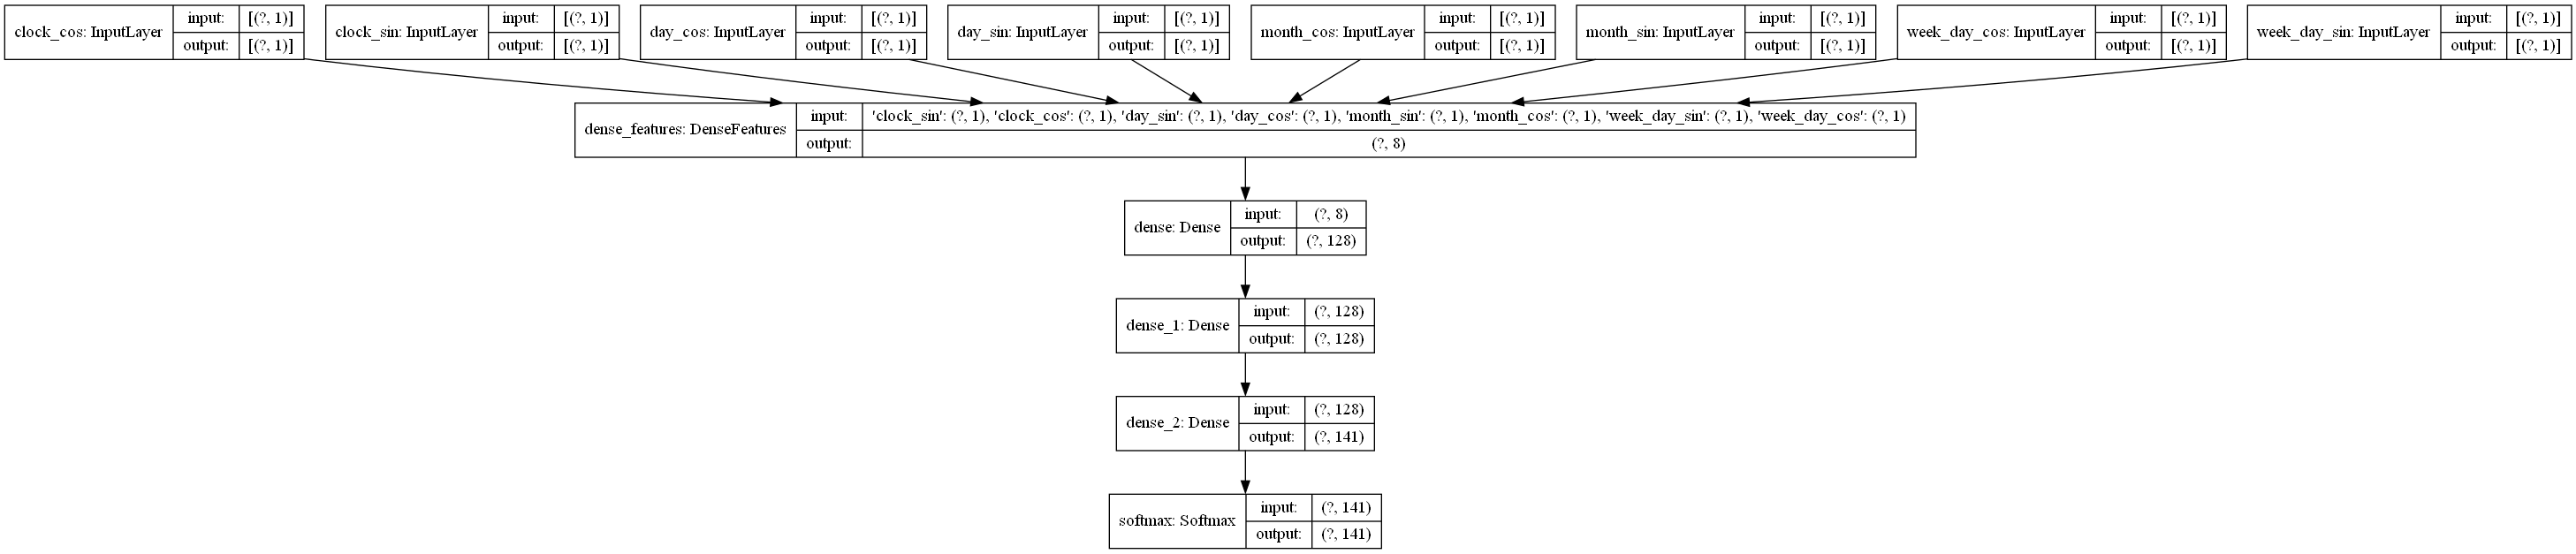

In [12]:
# Plot
from tensorflow.keras.utils import plot_model
plot_model(mh.model, '4square-locations-1-first-model.png', show_shapes=True)

The model is now trained for 30 epochs.

In [13]:
mh.set_num_epochs(30)
mh.fit_model(with_early_stopping=True)

Epoch 1/30
9098/9098 [==============================] - 7s 749us/step - loss: 3.1515 - sparse_categorical_accuracy: 0.2130 - val_loss: 3.2163 - val_sparse_categorical_accuracy: 0.2183
Epoch 2/30
9098/9098 [==============================] - 7s 720us/step - loss: 3.1266 - sparse_categorical_accuracy: 0.2169 - val_loss: 3.1897 - val_sparse_categorical_accuracy: 0.2115
Epoch 3/30
9098/9098 [==============================] - 7s 733us/step - loss: 3.1184 - sparse_categorical_accuracy: 0.2167 - val_loss: 3.1790 - val_sparse_categorical_accuracy: 0.2169
Epoch 4/30
9098/9098 [==============================] - 6s 690us/step - loss: 3.1117 - sparse_categorical_accuracy: 0.2174 - val_loss: 3.2021 - val_sparse_categorical_accuracy: 0.2093
Epoch 00004: early stopping


The evaluation on the test data is executed and the accuracy is printed.

In [14]:
mh.evaluate_model()

2843/2843 [==============================] - 1s 458us/step - loss: 3.2209 - sparse_categorical_accuracy: 0.2237


As expected, with such a simple approach, the accuracy is quite low.


## Second Model
The second model looks at the data in sequences of a fixed length N.
The data is split for each user and then in chunks of the size N.
Then, the prediction looks back at the given history and uses that information to make a prediction.
This should increase the prediction quality and thus result in a higher accuracy at the end.

In [15]:
df = pd.read_csv("./4square/processed_transformed_locations.csv")
df.head(100)

,location_id,user_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,0,470,-1.000000,0.000654,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
1,1,979,-0.999998,0.001818,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
2,2,69,-0.999945,0.010472,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
3,3,395,-0.999931,0.011708,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
4,0,87,-0.999914,0.013090,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
...,...,...,...,...,...,...,...,...,...,...
95,33,445,-0.959601,0.281365,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
96,0,235,-0.956326,0.292302,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
97,1,118,-0.955729,0.294249,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
98,20,1054,-0.955407,0.295291,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349


It is best, to use only the best 100 users for this purpose.
As they have the longest sequences of visited places.

In [16]:
# the number of different categories defines the vocabulary size
locations = df.location_id
vocab_size = locations.nunique()

print('vocabulary size:', vocab_size)

vocabulary size: 141


In [17]:
count = df.user_id.value_counts()

idx = count.loc[count.index[:100]].index # count >= 100
df = df.loc[df.user_id.isin(idx)]

In [18]:
user_ids = df.user_id.unique()
print(user_ids.size)

100


An array is created containing all visited locations for every user.
The original data is sorted by time (ascending).
Thus, the array contains a sequence of visited locations by user.

In [19]:
mh = ModelHelper(df, 17)
mh.set_vocab_size(vocab_size)

In [20]:
mh.set_target_column_name('location_id')
mh.set_numerical_column_names(numerical_column_names)
mh.set_column_names(column_names)
mh.set_client_column_name('user_id')
mh.set_client_column_ids()

In [21]:
mh.create_users_locations_from_df()

100%|██████████| 100/100 [00:00<00:00, 2636.80it/s]


[        location_id  user_id  clock_sin  clock_cos   day_sin   day_cos  \
 2                 2       69  -0.999945   0.010472  0.587785  0.809017   
 137               2       69  -0.915429   0.402480  0.587785  0.809017   
 495               2       69  -0.352726   0.935726  0.587785  0.809017   
 702               2       69   0.004872   0.999988  0.743145  0.669131   
 1103              2       69   0.925430   0.378918  0.743145  0.669131   
 ...             ...      ...        ...        ...       ...       ...   
 135897            2       69   0.836804  -0.547502 -0.406737 -0.913545   
 136620           30       69  -0.763702   0.645569 -0.406737 -0.913545   
 136874            3       69  -0.013817   0.999905 -0.406737 -0.913545   
 137420            3       69  -0.969641   0.244532 -0.587785 -0.809017   
 137421            3       69  -0.969410   0.245448 -0.587785 -0.809017   
 
         month_sin  month_cos  week_day_sin  week_day_cos  
 2        0.866025  -0.500000      0.7

It is necessary to first split the data in train, valid and test for each user.
Then, these are merged together again later on.
This is done to ensure that the sequences are kept together and not split randomly for the users.

In [22]:
mh.concat_split_users_locations(drop_client_column=False)

Tunable Parameters:

In [23]:
NUM_CLIENTS = user_ids.size
mh.set_batch_size(16)
mh.set_prefetch_buffer(8)

Next, data is split for the users to create client dictionaries containing each data slice.
Then, the federated data is generated.

In [24]:
mh.split_data_users()

100%|██████████| 100/100 [00:00<00:00, 690.70it/s]


In [25]:
mh.generate_client_dicts()

100%|██████████| 100/100 [00:00<00:00, 512.93it/s]


In [26]:
mh.generate_client_data()
mh.client_train_data

In [27]:
mh.generate_federated_data(sample_clients = mh.client_train_data.client_ids[0:NUM_CLIENTS])

100%|██████████| 100/100 [00:02<00:00, 43.86it/s]


In [28]:
print('\nNumber of client datasets: {l}'.format(l=len(mh.federated_train_data)))
print('First dataset: {d}'.format(d=mh.federated_train_data[0]))


Number of client datasets: 100
First dataset: <PrefetchDataset shapes: OrderedDict([(x, OrderedDict([(location_id, (16, 16)), (clock_sin, (16, 16)), (clock_cos, (16, 16)), (day_sin, (16, 16)), (day_cos, (16, 16)), (month_sin, (16, 16)), (month_cos, (16, 16)), (week_day_sin, (16, 16)), (week_day_cos, (16, 16))])), (y, (16, 16))]), types: OrderedDict([(x, OrderedDict([(location_id, tf.int32), (clock_sin, tf.float64), (clock_cos, tf.float64), (day_sin, tf.float64), (day_cos, tf.float64), (month_sin, tf.float64), (month_cos, tf.float64), (week_day_sin, tf.float64), (week_day_cos, tf.float64)])), (y, tf.int32)])>


The function that creates the keras model used for the training later on.

In [29]:
EMBEDDING_DIM = 256
rnn_units = 256

# Create a model
def create_keras_model():

  number_of_places = mh.vocab_size
  N = mh.total_window_length
  batch_size = mh.batch_size

  # Shortcut to the layers package
  l = tf.keras.layers

  # List of numeric feature columns to pass to the DenseLayer
  numeric_feature_columns = []

  # Handling numerical columns
  for header in numerical_column_names:
		# Append all the numerical columns defined into the list
    numeric_feature_columns.append(feature_column.numeric_column(header, shape=N-1))

  feature_inputs={}
  for c_name in numerical_column_names:
    feature_inputs[c_name] = tf.keras.Input((N-1,), batch_size=batch_size, name=c_name)

  # We cannot use an array of features as always because we have sequences
  # We have to do one by one in order to match the shape
  num_features = []
  for c_name in numerical_column_names:
    f =  feature_column.numeric_column(c_name, shape=(N-1))
    feature = l.DenseFeatures(f)(feature_inputs)
    feature = tf.expand_dims(feature, -1)
    num_features.append(feature)

  # Declare the dictionary for the locations sequence as before
  sequence_input = {
      'location_id': tf.keras.Input((N-1,), batch_size=batch_size, dtype=tf.dtypes.int32, name='location_id') # add batch_size=batch_size in case of stateful GRU
  }

  # Handling the categorical feature sequence using one-hot
  location_one_hot = feature_column.sequence_categorical_column_with_vocabulary_list(
      'location_id', [i for i in range(number_of_places)])

  # Embed the one-hot encoding
  location_embed = feature_column.embedding_column(location_one_hot, EMBEDDING_DIM)

  # With an input sequence we can't use the DenseFeature layer, we need to use the SequenceFeatures
  sequence_features, sequence_length = tf.keras.experimental.SequenceFeatures(location_embed)(sequence_input)

  input_sequence = l.Concatenate(axis=2)([sequence_features] + num_features)

  # Rnn
  recurrent = l.GRU(rnn_units,
                        batch_size=batch_size, #in case of stateful
                        dropout=0.3,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform')(input_sequence)


	# Last layer with an output for each places
  dense_1 = l.Dense(number_of_places)(recurrent)

	# Softmax output layer
  output = l.Softmax()(dense_1)

	# To return the Model, we need to define its inputs and outputs
	# In out case, we need to list all the input layers we have defined
  inputs = list(feature_inputs.values()) + list(sequence_input.values())

	# Return the Model
  return tf.keras.Model(inputs=inputs, outputs=output)

In [30]:
mh.assign_model(create_keras_model())

The preprocessing also works as intended.
Now, the model is trained and evaluated.
Logs are saved in a dedicated folder.

In [31]:
mh.model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(16, 16)]           0                                            
_______________________________________________________________________________________

In [32]:
mh.federated_training(create_keras_model)

Round 1
	Train: loss=1.766, accuracy=0.587
	Validation: loss=7.667, accuracy=0.289
	Saving best model..
 
	writing..
Round 2
	Train: loss=2.821, accuracy=0.538
	Validation: loss=2.709, accuracy=0.458
	Saving best model..
 
	writing..
Round 3
	Train: loss=1.173, accuracy=0.651
	Validation: loss=3.403, accuracy=0.182
 
	writing..
Round 4
	Train: loss=1.236, accuracy=0.634
	Validation: loss=2.736, accuracy=0.344
 
	writing..
Round 5
	Train: loss=1.160, accuracy=0.651
	Validation: loss=2.206, accuracy=0.501
	Saving best model..
 
	writing..
Round 6
	Train: loss=1.055, accuracy=0.675
	Validation: loss=2.059, accuracy=0.537
	Saving best model..
 
	writing..
Round 7
	Train: loss=1.011, accuracy=0.685
	Validation: loss=2.191, accuracy=0.460
 
	writing..
Round 8
	Train: loss=1.012, accuracy=0.685
	Validation: loss=2.450, accuracy=0.399
 
	writing..
Round 9
	Train: loss=1.037, accuracy=0.680
	Validation: loss=2.414, accuracy=0.415
 
	writing..
Round 10
	Train: loss=1.031, accuracy=0.682
	Validat

In [33]:
mh.federated_evaluation()

	Evaluation: loss=2.178, accuracy=0.510


The location prediction for the 4square data outperforms the NYC dataset.
When comparing it to the semantic prediction of categories, it becomes clear that predicting physical locations is an easier task for a deep learning network.
Most people or vehicles often remain in the same locations or just change their location to the neighboring areas for work or free time activities.
Even with much less logical locations than areas, users tend to have much more changes to the categories of the semantic locations.
For example, going to a restaurant after visiting multiple different stores could include a number of different location categories while only taking place in the same area.
As a result, deep learning networks have a harder time detecting patterns.
This explains the relatively poor performance of the 4square location category prediction compared to the location prediction.